In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# data preprocessing

In [8]:
action = pd.read_csv("./data/user_action.csv")
feed = pd.read_csv("./data/feed_info.csv")
feed = feed[['feedid','authorid','videoplayseconds']]
feed_emb = pd.read_csv("./data/feed_embeddings.csv")

In [9]:
action = pd.merge(left=action,right=feed,on=['feedid'],how='left').dropna(how='any')
action = pd.merge(left=action,right=feed_emb,on=['feedid'],how='left').dropna(how='any')

In [10]:
action = action[action.videoplayseconds<=60] # only use <= 60s videos

In [11]:
action['pcr'] = action['play'] / (action['videoplayseconds']*1000.0)
action['pcr'] = action['pcr'].apply(lambda x:min(1.0,x))

action['duration_level'] = (action[['videoplayseconds']]-1)//10

In [12]:
action.head(1)

,userid,feedid,date_,device,read_comment,comment,like,play,stay,click_avatar,forward,follow,favorite,authorid,videoplayseconds,feed_embedding,pcr,duration_level
0,8,71474,1,1,0,0,1,500,5366,0,0,0,0,1528,11,-0.04696813 -0.00618735 -0.04297943 0.00194003...,0.045455,1


# ostu label

In [13]:
def otsu(pcr,bins):
    threshold_t = 0
    max_g = 0
    
    for i in range(bins):
        t = i/bins
        n0 = pcr[np.where(pcr < t)]
        n1 = pcr[np.where(pcr >= t)]
        w0 = len(n0) / len(pcr)
        w1 = len(n1) / len(pcr)
        
        if w0 == 0 or w1 == 0:
            continue
        u0 = np.mean(n0) if len(n0) > 0 else 0.
        u1 = np.mean(n1) if len(n0) > 0 else 0.
        
        s0 = np.std(n0)
        s1 = np.std(n1)

        g = (w0 * w1 * ((u0 - u1) ** 2))/ (s0*w0+s1*w1)
        if g > max_g:
            max_g = g
            threshold_t = t
    return threshold_t


In [14]:
threshold = []
for i in range(6):
    x = action[action.duration_level==i][['pcr']]
    threshold.append(otsu(x['pcr'].to_numpy(),256))
threshold = pd.DataFrame(threshold).reset_index()
threshold.columns =['duration_level','threshold']
action = pd.merge(left=action,right=threshold,on=['duration_level'],how='left')
threshold

,duration_level,threshold
0,0,0.660156
1,1,0.644531
2,2,0.625000
3,3,0.593750
4,4,0.578125
5,5,0.566406


In [15]:
action['train_label'] = (action['pcr'] >= action['threshold']).astype('int32')

# post-feedback label

In [16]:
action['finish_playing'] = (action['pcr'] >= 1.0).astype('int32')

In [17]:
action['test_label'] = (action['read_comment'] | action['like'])

In [18]:
action = action[~((action.train_label==0) & (action.test_label==1))]

# visual

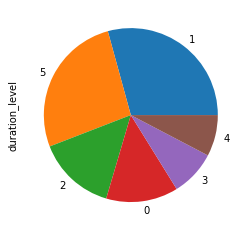

In [22]:
action['duration_level'].value_counts().plot('pie')

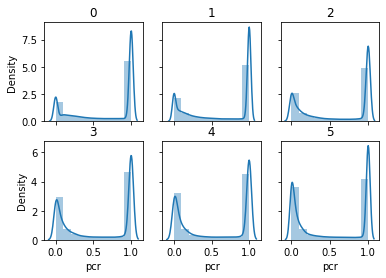

In [41]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
for i in range(2):
    for j in range(3):
        sns.distplot(action[action.duration_level == i*3+j]['pcr'],ax = ax[i,j],bins=10)
        ax[i,j].set_title(str(i*3+j))

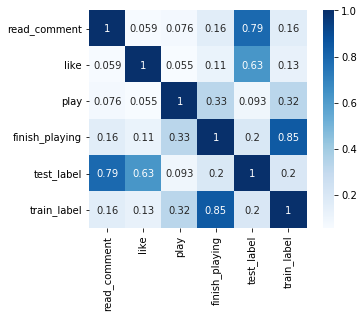

In [29]:
corr= action[['read_comment','like','play','finish_playing','test_label','train_label']].corr()
sns.heatmap(corr,annot = True,vmax = 1,square = True,cmap = "Blues")

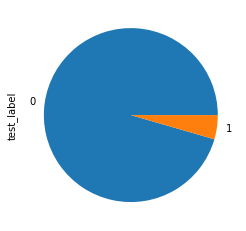

In [70]:
action['test_label'].value_counts().plot("pie")

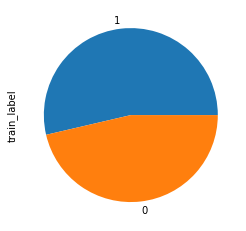

In [71]:
action['train_label'].value_counts().plot("pie")

In [132]:
feed = action.sort_values(by=['date_'])

train= feed.groupby('userid').apply(lambda x: x[:int(len(x)*0.6)]).reset_index(drop=True)
valid= feed.groupby('userid').apply(lambda x: x[int(len(x)*0.6):int(len(x)*0.8)]).reset_index(drop=True)
test= feed.groupby('userid').apply(lambda x: x[int(len(x)*0.8):]).reset_index(drop=True)

# save

In [20]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
action['userid'] = enc.fit_transform(action['userid'].to_numpy().reshape(-1,1)).astype("int32")

enc = OrdinalEncoder()
action['feedid'] = enc.fit_transform(action['feedid'].to_numpy().reshape(-1,1)).astype("int32")

enc = OrdinalEncoder()
action['authorid'] = enc.fit_transform(action['authorid'].to_numpy().reshape(-1,1)).astype("int32")

feed_emb = action[['feedid','feed_embedding']].drop_duplicates(['feedid']).sort_values(by=['feedid'])

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components = 64) 
emb = np.array(feed_emb['feed_embedding'].apply(lambda x: [float(i) for i in x.split(' ')[:-1]]).tolist())
res = pca.fit_transform(emb)
emb = pd.DataFrame(res,columns = [i for i in range(64)])

In [22]:
np.save('./input/feedid_emb_64.npy',emb.to_numpy())

In [28]:
action.drop('feed_embedding',axis=1,inplace=True)

In [32]:
action.to_csv("./input/action.csv",index=False)